# 第3章 多層パーセプトロン

## 3.1 MLPの構築と学習

* 線形層をつなげるだけだと全体としては線形の関数にしかならない
* 間に活性化関数（e.g. ReLU）を挟むことで非線形な表現を可能にする
* 層が一直線に積み重なった形のNNをfeedforward型という
* feedforward型NNの微分を求める際には動的計画法を用いたアルゴリズム（backpropagation）を使用する

In [1]:
%matplotlib inline
import torch
from torch import nn, optim
from sklearn.datasets import load_digits
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
# gpuを使えるときはgpuを使う
device = "cuda" if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# nn.Sequentialはnn.Moduleの層を積み重ねてネットワークを構築する際に使用する
net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
).to(device)
print(net)

Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=10, bias=True)
)


In [4]:
# 学習
digits = load_digits()

X = digits.data
Y = digits.target

# どっちでもいい？
# X = torch.Tensor(X).cuda()
# Y = torch.LongTensor(y).cuda()
X = torch.Tensor(X).to(device)
Y = torch.LongTensor(Y).to(device)
print(X.shape)
print(Y.shape)

# 損失関数
loss_fn = nn.CrossEntropyLoss()

# Adam（SGDの改良版アルゴリズム）
optimizer = optim.Adam(net.parameters())

# 損失関数のログ
losses = []

torch.Size([1797, 64])
torch.Size([1797])


In [5]:
# iteration
for epoch in range(500):
    # 勾配の削除
    optimizer.zero_grad()
    
    # 予測値の計算
    y_pred = net(X)
    
    # 損失と勾配の計算
    loss = loss_fn(y_pred, Y)
    loss.backward()
    
    # 勾配の更新
    optimizer.step()
    
    # 損失の記録
    losses.append(loss.item())

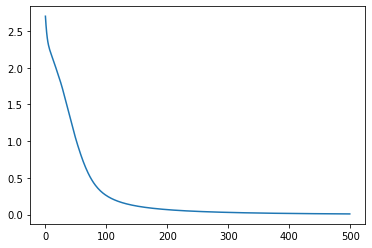

In [6]:
# 損失関数の収束を確認
plt.plot(losses)

## 3.2 DatasetとDataLoader
* データが多くなる、ネットワークが深くなると、全てのデータがメモリに乗らなくなる
* データの一部（ミニバッチ）を使用するのが本来のSGD（これまでは全部使ってた）
* ミニバッチ学習、データのシャッフル、並列処理はDatasetとDataLoaderを使って簡単に行うことができる
* TensorDataset（Datasetを継承したクラス）をDataLoaderに渡すことで、forループでデータの一部のみを簡単に受け取れる

In [7]:
from torch.utils.data import TensorDataset, DataLoader

# Datasetを作成
ds = TensorDataset(X, Y)

# 異なる順番で64個ずつデータを返すDataLoaderを作成
loader = DataLoader(ds, batch_size=64, shuffle=True)

net = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.ReLU(),
    nn.Linear(16, 10)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

In [8]:
# 最適化を実行
losses = []

for epoch in tqdm(range(100)):
    running_loss = 0.0
    
    for x, y in loader:
        # x, yは64個のみ受け取る
        y_pred = net(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    losses.append(running_loss)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:17<00:00,  5.63it/s]


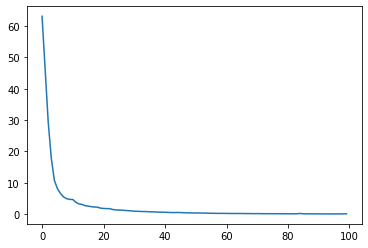

In [9]:
# 損失関数の収束を確認
plt.plot(losses)

## 3.3 学習効率化のTips

### 3.3.1 Dropoutによる正則化
* 深いNNはパラメータが多く、過学習が起こりやすい
* 過学習を抑える＝正則化
* Dropout: ランダムにいくつかのノード（変数の次元）を意図的に使用しない
* Dropoutは学習時のみに行い、予測時には使用しない
* pytorchではモデルのtrainとevalメソッドで挙動を切り替えることができる

In [10]:
# 過学習の例
from sklearn.model_selection import train_test_split

# 全体の30%をtestにする
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

# 層を積み重ねて深いNNを構築する
k = 100
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Linear(k, 10)
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# DataLoader作成
ds = TensorDataset(X_train, y_train)
loader = DataLoader(ds, batch_size=32, shuffle=True)

train_losses = []
test_losses = []

for epoch in tqdm(range(100)):
    running_loss = 0.0
    
    for i, (x, y) in enumerate(loader):
        y_pred = net(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    train_losses.append(running_loss / i)
    
    # 予測
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, y_test)
    test_losses.append(test_loss.item())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.41it/s]


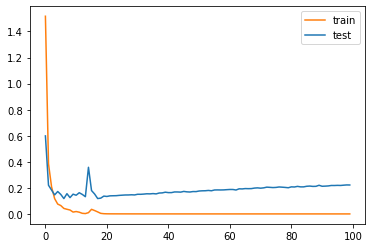

In [11]:
# 損失関数の過学習を確認
# epocが大きくなると損失が逆に大きくなっている
plt.plot(train_losses, color="tab:orange", label="train")
plt.plot(test_losses, color="tab:blue", label="test")
plt.legend()

In [13]:
# Dropoutの実装
# 各層において、確率0.5でランダムに変数の次元を捨てる
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(k, 10)
).to(device)

optimizer = optim.Adam(net.parameters())

train_losses = []
test_losses = []

for epoch in tqdm(range(100)):
    running_loss = 0.0
    
    # ネットワークを学習モードにする（dropoutやbatch normalizationを有効化）
    net.train()
    
    for i, (x, y) in enumerate(loader):
        y_pred = net(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    train_losses.append(running_loss / i)
    
    # ネットワークを評価モードにする（dropoutやbatch normalizationを有効化）
    net.eval()

    # testデータの損失関数を計算
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, y_test)
    test_losses.append(test_loss.item())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:29<00:00,  3.45it/s]


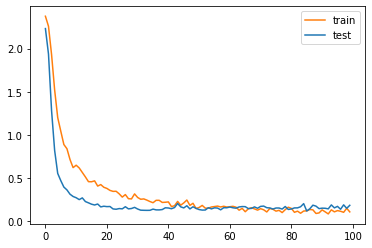

In [14]:
# 過学習の抑制を確認
# epocが大きくなっても損失が大きくならない
plt.plot(train_losses, color="tab:orange", label="train")
plt.plot(test_losses, color="tab:blue", label="test")
plt.legend()

### 3.3.2 Batch Normalizationによる学習の加速
* SGDを使用したNNの学習では各変数の次元が同じような値の範囲をとることが重要
* 深いNNでは層が進むにつれてデータの分布が変わるので入力データの正規化だけでは不十分
* 前の層の学習によってパラメータが変動し、後ろの層の学習が不安定になってしまう
* Batch Normalization: 上記の問題を緩和し、学習の安定化と加速に寄与
* Batch Normalizationも学習時のみ適用し、評価時には使用しない

In [15]:
# Linear総にはBatchNorm1dを適用する
net = nn.Sequential(
    nn.Linear(64, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, k),
    nn.ReLU(),
    nn.BatchNorm1d(k),
    nn.Linear(k, 10)
).to(device)

# 以降はDropoutと同じ
optimizer = optim.Adam(net.parameters())

train_losses = []
test_losses = []

for epoch in tqdm(range(100)):
    running_loss = 0.0
    
    # ネットワークを学習モードにする
    net.train()
    
    for i, (x, y) in enumerate(loader):
        y_pred = net(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    train_losses.append(running_loss / i)
    
    # ネットワークを評価モードにしてtestデータの損失関数を計算する
    net.eval()
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, y_test)
    test_losses.append(test_loss.item())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.96it/s]


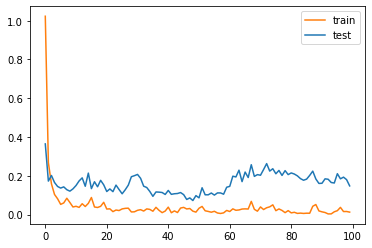

In [16]:
# lossを確認
# 微妙...？
plt.plot(train_losses, color="tab:orange", label="train")
plt.plot(test_losses, color="tab:blue", label="test")
plt.legend()

## 3.4 ネットワークのモジュール化
* 独自のネットワーク層を定義する
* nn.Moduleはnn.Linearなどの全ての層の基底クラスなので、これを継承したカスタム層を作ることができる
* カスタム層を作る際には、forwardメソッドを実装すれば、自動微分まで可能になる
* これまでの実装は、nn.Modlueの\__call\__メソッドが内部でforwardメソッドを使用しているためできていた（カスタム層の場合はこれを自分で作る必要がある）

In [24]:
class CustomLinear(nn.Module):
    """
    カスタム層の定義
    Linear -> ReLU -> Dropout
    """
    def __init__(self, in_features, out_features, bias=True, p=0.5):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.drop(x)
        return x

In [28]:
# カスタム層を使ったネットワークの構築
net = nn.Sequential(
    CustomLinear(64, 200),
    CustomLinear(200, 200),
    CustomLinear(200, 200),
    nn.Linear(200, 10)
).to(device)

In [29]:
# 以降は同じ
optimizer = optim.Adam(net.parameters())

train_losses = []
test_losses = []

for epoch in tqdm(range(100)):
    running_loss = 0.0
    
    # ネットワークを学習モードにする
    net.train()
    
    for i, (x, y) in enumerate(loader):
        y_pred = net(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    train_losses.append(running_loss / i)
    
    # ネットワークを評価モードにしてtestデータの損失関数を計算する
    net.eval()
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, y_test)
    test_losses.append(test_loss.item())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.57it/s]


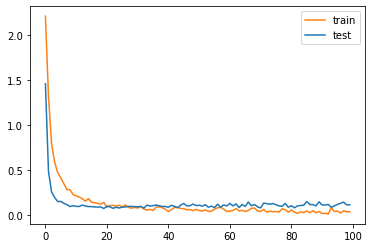

In [30]:
# lossを確認
plt.plot(train_losses, color="tab:orange", label="train")
plt.plot(test_losses, color="tab:blue", label="test")
plt.legend()

In [37]:
class MyMLP(nn.Module):
    """
    カスタム層の定義2
    nn.Sequentialのネットワーク構築部分まで含む実装
    """
    def __init__(self, in_features, out_features):
        super().__init__()
        self.ln1 = CustomLinear(in_features, 200)
        self.ln2 = CustomLinear(200, 200)
        self.ln3 = CustomLinear(200, 200)
        self.ln4 = CustomLinear(200, 200)
        self.ln5 = nn.Linear(200, out_features)
    
    def forward(self, x):
        x = self.ln1(x)
        x = self.ln2(x)
        x = self.ln3(x)
        x = self.ln4(x)
        x = self.ln5(x)
        return x

In [38]:
net = MyMLP(64, 10).to(device)

In [39]:
# 以降は同じ
optimizer = optim.Adam(net.parameters())

train_losses = []
test_losses = []

for epoch in tqdm(range(100)):
    running_loss = 0.0
    
    # ネットワークを学習モードにする
    net.train()
    
    for i, (x, y) in enumerate(loader):
        y_pred = net(x)
        loss = loss_fn(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    train_losses.append(running_loss / i)
    
    # ネットワークを評価モードにしてtestデータの損失関数を計算する
    net.eval()
    y_pred = net(X_test)
    test_loss = loss_fn(y_pred, y_test)
    test_losses.append(test_loss.item())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.03it/s]


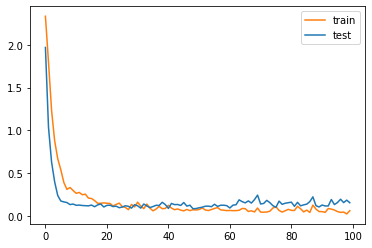

In [40]:
# lossを確認
plt.plot(train_losses, color="tab:orange", label="train")
plt.plot(test_losses, color="tab:blue", label="test")
plt.legend()